# Comparison XGBoost with Gating


In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.utils import list_of_dict_to_dict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP

# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier

from sklearn import manifold, datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.dummy import DummyClassifier

def classification_complete_report(estimator, X, y_true, labels = None ,plot = True ): 
    y_pred = estimator.predict(X)
    y_pred_dummy = DummyClassifier().fit(X,y_true).predict(X)
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("No information rate: %.2f" % accuracy_score(y_true, y_pred_dummy) )
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true, labels = labels ,cmap = "Greys", xticks_rotation='vertical')
    

now lets load the data

In [3]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1
...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1


In [4]:

df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")
df_features

,mask_based_area_BF,mask_based_bbox_area_BF,mask_based_convex_area_BF,mask_based_eccentricity_BF,mask_based_equivalent_diameter_BF,mask_based_euler_number_BF,mask_based_extent_BF,mask_based_feret_diameter_max_BF,mask_based_filled_area_BF,mask_based_major_axis_length_BF,...,max_intensity_ratio_MHCII_R7_R8,sum_intensity_ratio_CD3_R7_R8,mean_intensity_ratio_CD3_R7_R8,max_intensity_ratio_CD3_R7_R8,sum_intensity_ratio_P-CD3zeta_R7_R8,mean_intensity_ratio_P-CD3zeta_R7_R8,max_intensity_ratio_P-CD3zeta_R7_R8,sum_intensity_ratio_Live-Dead_R7_R8,mean_intensity_ratio_Live-Dead_R7_R8,max_intensity_ratio_Live-Dead_R7_R8
0,2228,3021,2392,0.484394,53.261409,1,0.737504,61.717096,2228,57.336477,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,885,1155,925,0.238094,33.568095,1,0.766234,36.138622,885,34.216438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,656,812,689,0.369856,28.900608,1,0.807882,32.756679,656,30.262314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,753,899,780,0.386491,30.963678,1,0.837597,34.132096,753,32.348559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1208,1512,1247,0.661747,39.218279,1,0.798942,51.224994,1208,45.782110,...,19.735296,0.465222,0.465222,25.504583,0.481531,0.481531,26.397369,0.754085,0.754085,45.835530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,973,1190,997,0.100885,35.197473,1,0.817647,37.215588,973,35.332773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065963,3956,5046,4180,0.787555,70.971372,1,0.783987,91.760558,3956,91.437834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065964,909,1073,928,0.622298,34.020211,1,0.847158,40.804412,909,38.830446,...,5.716450,0.190820,0.190820,7.474995,0.115499,0.115499,4.191402,1.000000,1.000000,32.928658
1065965,3388,4272,3670,0.875994,65.679035,1,0.793071,90.426766,3388,96.830707,...,6.247939,0.039196,0.039196,124.378412,0.045108,0.045108,140.202637,0.005466,0.005466,16.385927


to avoid using irrelevant or meaningless features in our analysis, we exclude features which include these strings

In [5]:
list_of_features_to_exclude = ["Antibody","Live-Dead","CD18",  "_R2",  "_R3",  "_R8", "background",
                               "moment","percent","mask_based_mean","mask_based_min","mask_based_max",  
                               "RMS","intensity_BF","_R1_R2","_R1_R3","_R1_R4","_R1_R5","_R1_R6","_R1_R7",
                               "_R1_R8","_R2_R1","_R2_R3","_R2_R4","_R2_R5","_R2_R6","_R2_R7","_R2_R8",
                               "_R3_R1","_R3_R2","_R3_R4","_R3_R5","_R3_R6","_R3_R7","_R3_R8",
                               "_R4_R1","_R4_R2","_R4_R3","_R4_R5","_R4_R6","_R4_R7","_R4_R8",
                               "_R5_R1","_R5_R2","_R5_R3","_R5_R4","_R5_R8","_R6_R1","_R6_R2",
                               "_R6_R3","_R6_R4","_R6_R5","_R6_R7","_R6_R8","_R7_R1","_R7_R2",
                               "_R7_R3","_R7_R4","_R7_R5","_R7_R6","_R7_R8","_R8_R1","_R8_R2",
                               "_R8_R3","_R8_R4","_R8_R5","_R8_R6","_R8_R7","cell_distance"]
classification_indx = ~df_features.columns.str.contains( list_of_features_to_exclude[0]) 

for f_to_exclude in list_of_features_to_exclude:
    classification_indx = classification_indx & ~df_features.columns.str.contains( f_to_exclude) 
    

print("list of remained columns:\n", 
      df_features.columns[classification_indx],
     "\n",
     "so we have these many columns:",
     classification_indx.sum())

list of remained columns:
 Index(['mask_based_area_BF', 'mask_based_bbox_area_BF',
       'mask_based_convex_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_equivalent_diameter_BF', 'mask_based_euler_number_BF',
       'mask_based_extent_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_filled_area_BF', 'mask_based_major_axis_length_BF',
       ...
       'max_intensity_ratio_F-Actin_R5_R7', 'sum_intensity_ratio_MHCII_R5_R7',
       'mean_intensity_ratio_MHCII_R5_R7', 'max_intensity_ratio_MHCII_R5_R7',
       'sum_intensity_ratio_CD3_R5_R7', 'mean_intensity_ratio_CD3_R5_R7',
       'max_intensity_ratio_CD3_R5_R7', 'sum_intensity_ratio_P-CD3zeta_R5_R7',
       'mean_intensity_ratio_P-CD3zeta_R5_R7',
       'max_intensity_ratio_P-CD3zeta_R5_R7'],
      dtype='object', length=247) 
 so we have these many columns: 247


now we use the pre-assigned set of train, validation and test

In [6]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

In [7]:
top_k = 196

In [9]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder().fit(metadata.loc[train_index.tolist() + validation_index.tolist() , "label"])

xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = top_k )),
                 ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
        ], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist() , classification_indx],  
              le.transform( metadata.loc[train_index.tolist() + validation_index.tolist() , "label"]) )

[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  18.1s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=   2.0s


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('AutoFeatureSelection', AutoFeatureSelection(top_k=196)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
       

# Model evaluation

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       161
           1       0.99      0.98      0.99       190
           2       0.94      0.92      0.93       154
           3       0.96      0.96      0.96       182
           4       0.88      0.89      0.88       196
           5       0.83      0.88      0.85       147
           6       0.89      0.92      0.91       200
           7       0.95      0.92      0.93       189
           8       0.90      0.83      0.87       148

    accuracy                           0.92      1567
   macro avg       0.92      0.91      0.91      1567
weighted avg       0.92      0.92      0.92      1567

------------------------------------------------------------
No information rate: 0.13
matthews correlation coeff: 0.91
Cohen Kappa score: 0.91
Accuracy: 0.92 & balanced Accuracy: 0.91
macro F1 score: 0.91 & micro F1 score: 0.92
macro Precision score: 0.92 & micro Precision score: 0.92
macro Re

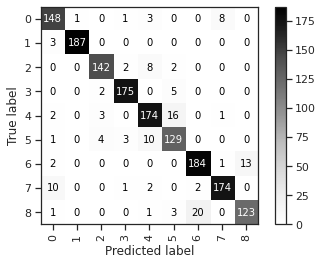

In [10]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, classification_indx],
                               le.transform(metadata.loc[test_index, "label"]))

## Comparison with gating

In [14]:
gating_comparison = pd.read_csv("gating_comparison.csv").dropna()

In [16]:
gating_comparison["object_number"] = gating_comparison["object_number"].astype(int)

In [17]:
gating_comparison

,object_number,gating strategy,ml,expert,gating correct,curated by KE
0,17,Synapse without signaling,None,Synapse with signaling,0.0,0.0
1,1078,Multiplets_I,None,Multiplets,1.0,1.0
2,1480,unfocused,None,unfocused single T cell without signaling,1.0,1.0
3,1965,gated out,None,Synapse with signaling (but one unfocused cell...,0.0,1.0
4,2292,Multiplets_II,None,Unknown (one single Synapse with signaling and...,0.0,0.0
...,...,...,...,...,...,...
105,271780,?,None,single T cell without signaling (T cell is ver...,0.0,0.0
106,272911,single T cell without signaling,None,single T cell without signaling,1.0,1.0
107,273445,no cell-cell interaction,None,no cell-cell interaction,1.0,1.0
108,273608,unfocused,None,unfocused single T cell without signaling,0.0,1.0


In [24]:
row_index = metadata["label"].isin(set_of_interesting_classes)
row_index = row_index & (metadata["condition"].isin(["-SEA","+SEA"]))
row_index = row_index & (metadata["experiment"].isin(["Experiment_1"]))

metadata.loc[row_index,"object_number"].isin(gating_comparison.object_number).sum()

2